#### Build ResnNet18 over cifar10

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# cd to where you put resnet.py
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet import *


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01

In [6]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..


### training

In [ ]:

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss


def test(epoch):
    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss


In [ ]:
train_losses = []
test_losses = []

for epoch in range(0,40):
    trl = train(epoch)
    train_losses.append(trl)
    tstl = test(epoch)
    test_losses.append(tstl)
    scheduler.step()

print('Accuracy of the network on the test images: %d %%' % (acc))

[565.3478790521622, 368.41895842552185, 286.9470936655998, 240.13479721546173, 205.73215746879578, 184.15975749492645, 166.02828007936478, 150.86289237439632, 139.35495771467686, 129.07502849400043, 120.29470273852348, 111.3263489305973, 106.03369195759296, 98.76329117268324, 94.87129108607769, 88.59207692742348, 85.03814271092415, 78.65169991925359, 74.91987405717373, 70.65096627548337, 66.582962885499, 63.103892132639885, 63.42591020092368, 56.735269628465176, 57.57031409069896, 52.78323790803552, 53.198398139327765, 48.30326868221164, 45.71889441460371, 45.73125679604709, 43.363538801670074, 40.45368825830519, 39.53770394809544, 37.26620310917497, 36.30282591097057, 34.47617950104177, 32.73876299522817, 33.3066647015512, 30.145455995574594, 29.40655600093305]
[118.41340851783752, 96.7493726015091, 73.29795423150063, 65.96601635217667, 59.366617023944855, 60.882470309734344, 55.408654898405075, 48.192844331264496, 48.77205242216587, 49.19631379842758, 42.903468534350395, 36.930100098

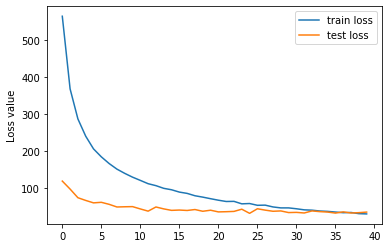

In [ ]:
import matplotlib.pyplot as plt
print(train_losses)
print(test_losses)
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.ylabel('Loss value')
plt.legend()
plt.show()

# Saving

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'hw3_resnet')

# Loading

In [7]:
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer =optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

checkpoint = torch.load('hw3_resnet')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = checkpoint['loss']

net.eval()
# - or -
# model.train()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

## Evaluating

In [8]:
imgloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
dataiter = iter(imgloader)
org_images, org_labels = dataiter.next()

In [9]:
org_labels = org_labels.to(device)
org_images = org_images.to(device)
outputs= net(org_images)
_, predicted = torch.max(outputs.data, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


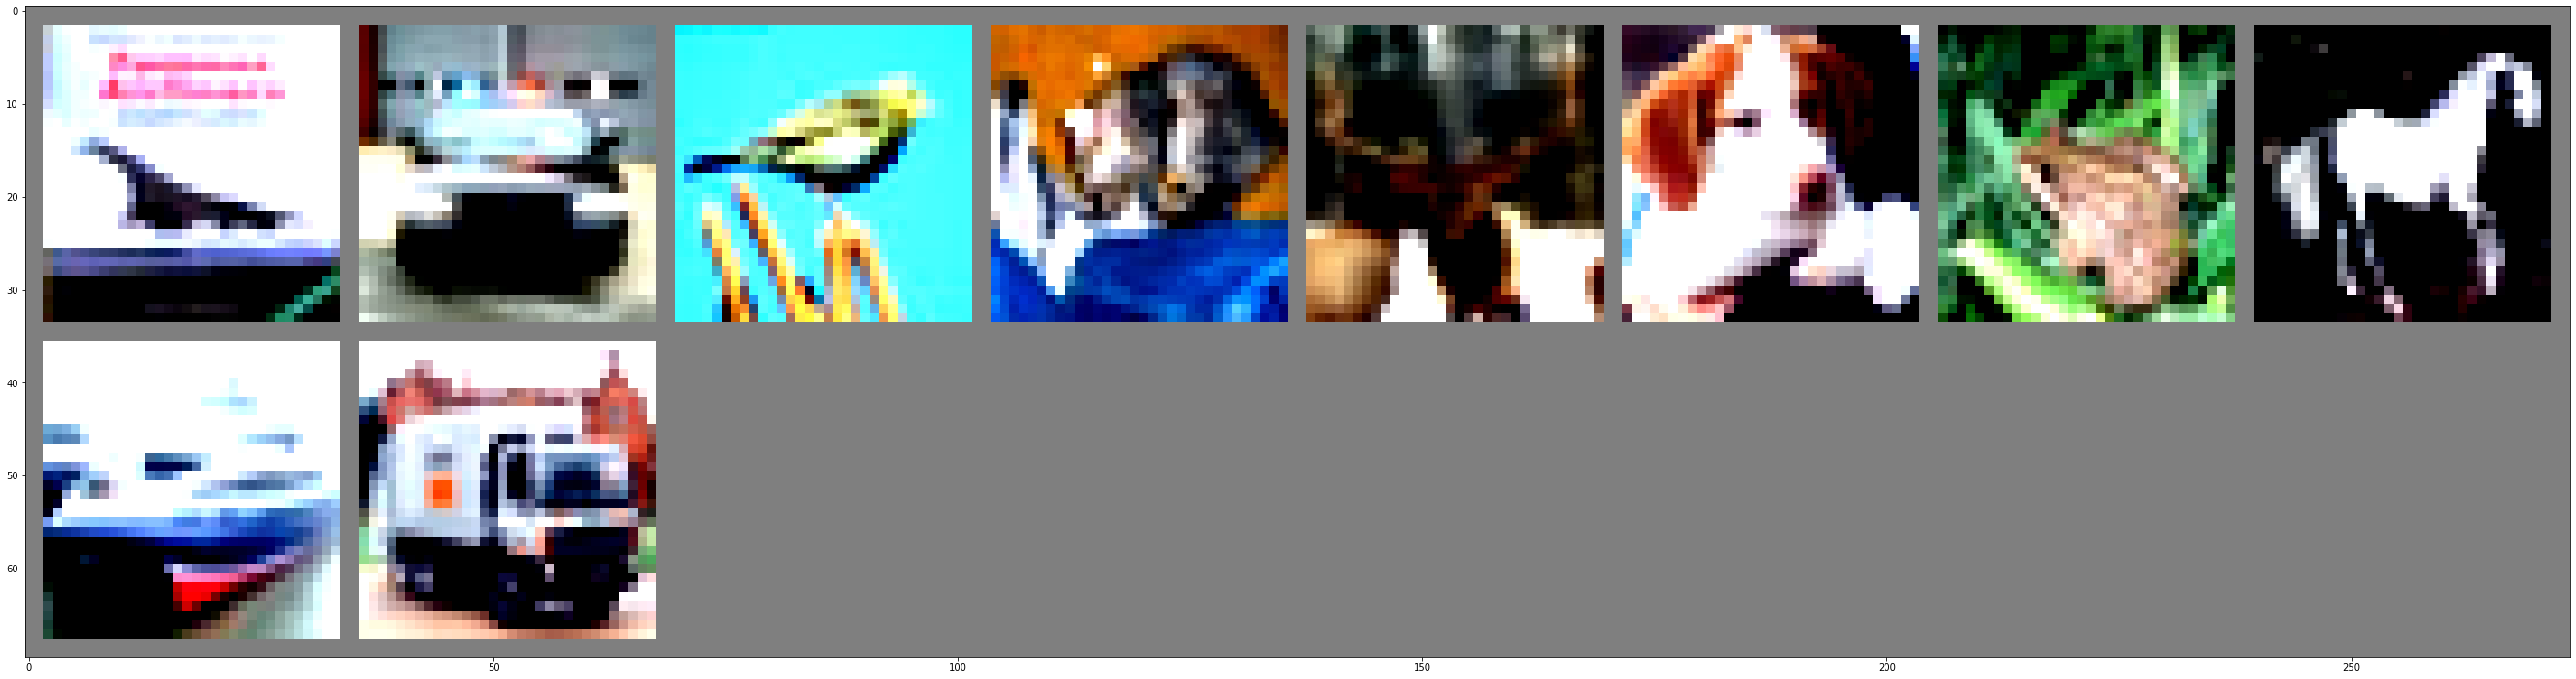

In [10]:
def imshow(img,sz=50):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(sz,sz))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


samples = []
samples_labels = []
samples_pred = []
selected = [3,66,67,0,26,16,4,13,1,11]

for i in selected:
  samples.append(org_images[i])
  samples_labels.append(org_labels[i])
  samples_pred.append(outputs[i])
samples = torch.stack(samples)
samples_labels = torch.stack(samples_labels)
samples_pred = torch.stack(samples_pred)
imshow(torchvision.utils.make_grid(samples.cpu()))

In [ ]:
_, pred = torch.max(samples_pred.data, 1)

if not torch.all(torch.eq(pred,samples_labels)) :
  print("CAUTION: Your model was not sufficiently trained and contain an error. Retrain it!")
else:
  print('ok')

ok


In [ ]:
samples_labels

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

# FGSM

In [ ]:
base_eps = 1/255

In [ ]:
def fgsm(x,targets,net,epsilon):
    # Collect the element-wise sign of the data gradient
    x.requires_grad = True
    outputs= net(x)
    net.zero_grad()
    loss = criterion(outputs, targets)
    loss.backward()
    data_grad = x.grad.data
    sign_data_grad = data_grad.sign()
    perturbation = epsilon*sign_data_grad
    perturbed_image = x + perturbation
    outputs= net(perturbed_image)
    return perturbed_image,perturbation,outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([8], device='cuda:0') tensor([0], device='cuda:0')


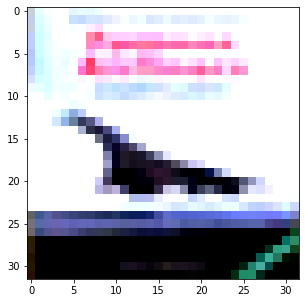

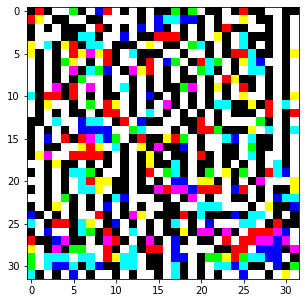

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


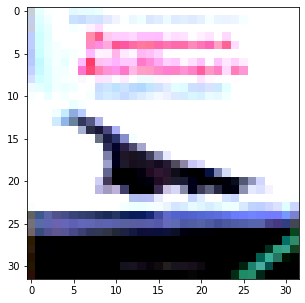

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([8], device='cuda:0') tensor([1], device='cuda:0')


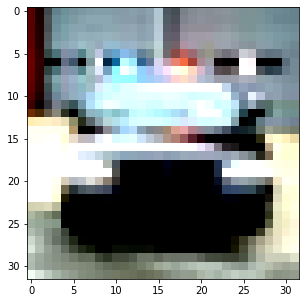

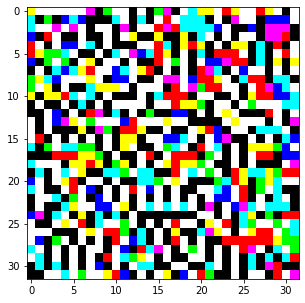

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


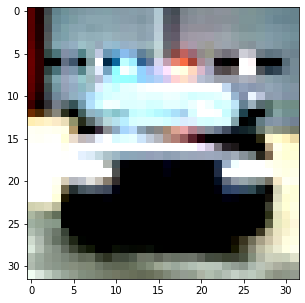

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1], device='cuda:0') tensor([2], device='cuda:0')


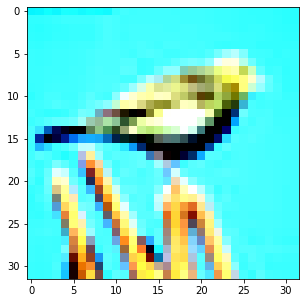

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


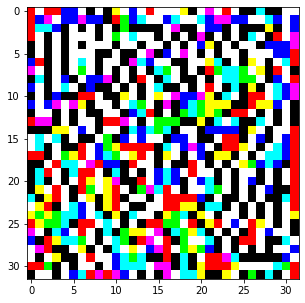

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


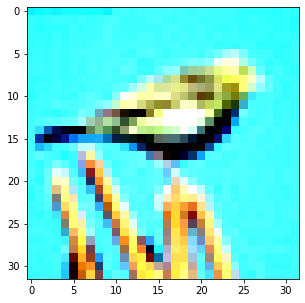

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1], device='cuda:0') tensor([3], device='cuda:0')


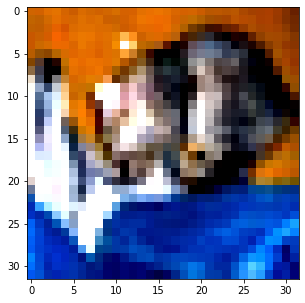

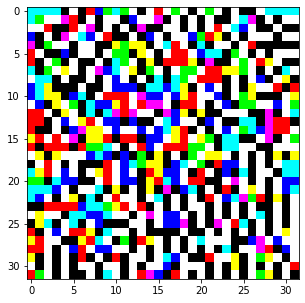

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


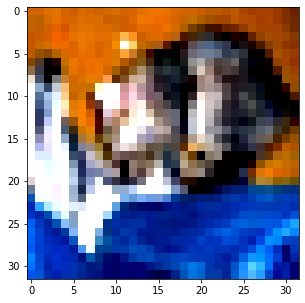

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3], device='cuda:0') tensor([4], device='cuda:0')


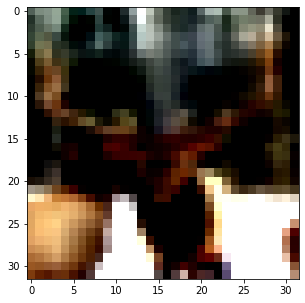

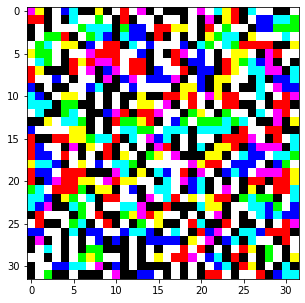

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


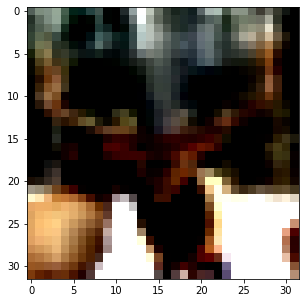

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([7], device='cuda:0') tensor([5], device='cuda:0')


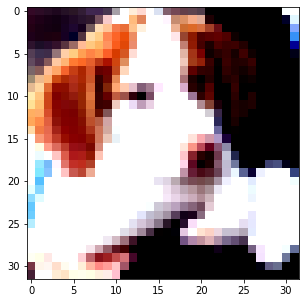

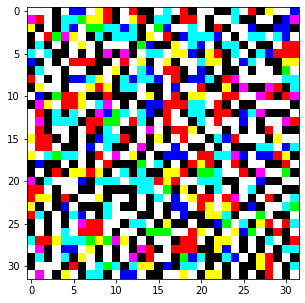

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


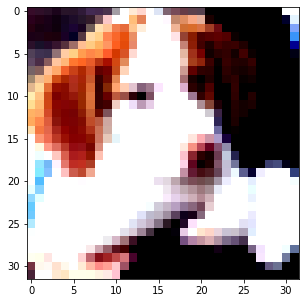

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9], device='cuda:0') tensor([6], device='cuda:0')


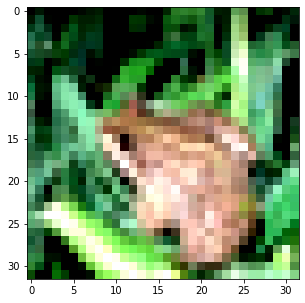

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


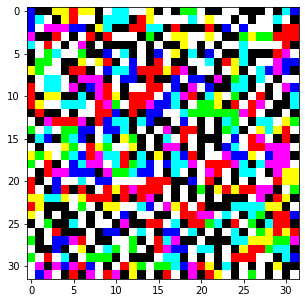

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


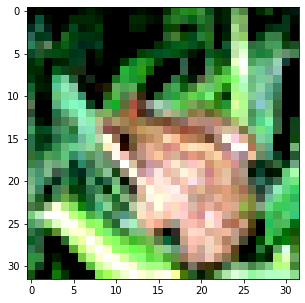

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3], device='cuda:0') tensor([7], device='cuda:0')


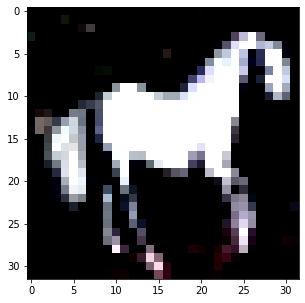

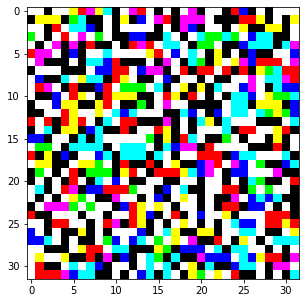

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


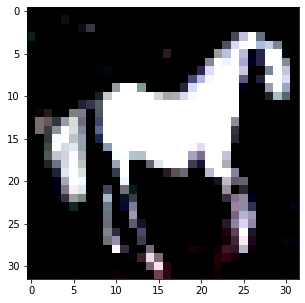

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1], device='cuda:0') tensor([8], device='cuda:0')


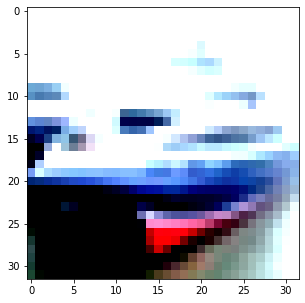

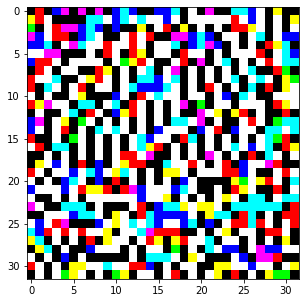

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


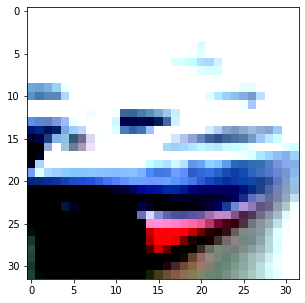

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1], device='cuda:0') tensor([9], device='cuda:0')


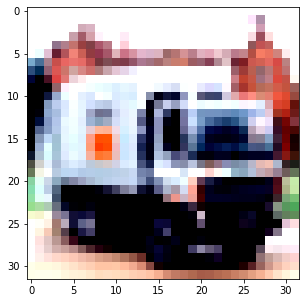

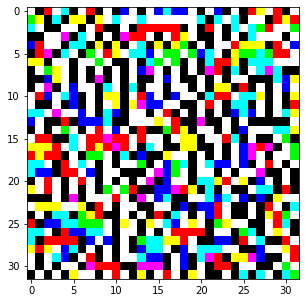

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


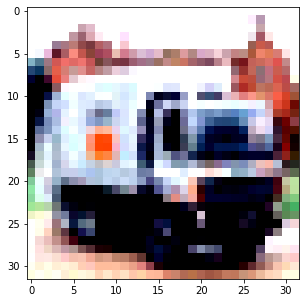

In [ ]:

for i in selected:
  image = org_images[i:i+1]
  targets = org_labels[i:i+1]
  eps = base_eps
  success = False
  while not success:
    perturbed_image,perturbation,outputs = fgsm(image,targets,net,eps)
    _, predicted = torch.max(outputs.data, 1)
    if predicted!=targets:
      success = True
      print(predicted,targets)
      imshow(image[0].detach().cpu(),5)
      imshow((perturbation[0]*(1/eps)).detach().cpu(),5)
      imshow(perturbed_image[0].detach().cpu(),5)
    eps += base_eps

# FGSM Adversarial Trainig

In [ ]:
# Model
print('==> Building model..')
adv_net = ResNet18()
adv_net = adv_net.to(device)
if device == 'cuda':
    adv_net = torch.nn.DataParallel(adv_net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [ ]:
eps = 8/255
# Training
def adversarially_train(epoch):
    print('\nEpoch: %d' % epoch)
    adv_net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        perturbed_image,perturbation,outputs = fgsm(inputs,targets,adv_net,eps)
        optimizer.zero_grad()
        # outputs = adv_net(perturbed_image)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss


def test(epoch):
    global acc
    adv_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = adv_net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss

train_losses = []
test_losses = []

for epoch in range(0,40):
    trl = adversarially_train(epoch)
    train_losses.append(trl)
    tstl = test(epoch)
    test_losses.append(tstl)
    scheduler.step()

print('Accuracy of the network on the test images: %d %%' % (acc))


Epoch: 0

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20

Epoch: 21

Epoch: 22

Epoch: 23

Epoch: 24

Epoch: 25

Epoch: 26

Epoch: 27

Epoch: 28

Epoch: 29

Epoch: 30

Epoch: 31

Epoch: 32

Epoch: 33

Epoch: 34

Epoch: 35

Epoch: 36

Epoch: 37

Epoch: 38

Epoch: 39
Accuracy of the network on the test images: 88 %


[714.628783583641, 584.8507264852524, 507.5045816898346, 447.8996077775955, 411.20979833602905, 380.1934584379196, 355.85337966680527, 334.25410878658295, 319.07600528001785, 302.58516013622284, 292.6423625946045, 280.4706629514694, 269.1276872754097, 257.30746310949326, 249.09214034676552, 242.3584949374199, 233.56158593297005, 226.93227899074554, 218.62197482585907, 210.92040899395943, 207.24544423818588, 199.7695226073265, 195.10069102048874, 189.07051500678062, 182.747772783041, 177.14118167757988, 171.53977173566818, 166.93287816643715, 162.04824101924896, 158.6555352807045, 152.3795501291752, 148.36449451744556, 143.88113121688366, 138.90886710584164, 136.72780250012875, 133.00195279717445, 128.41164496541023, 124.78159722685814, 120.52016554772854, 116.34048311412334]
[140.78008198738098, 115.99366664886475, 104.88261198997498, 81.33173429965973, 80.39066457748413, 70.1724671125412, 61.47028782963753, 61.64246329665184, 57.76728814840317, 56.166270434856415, 51.591216415166855, 

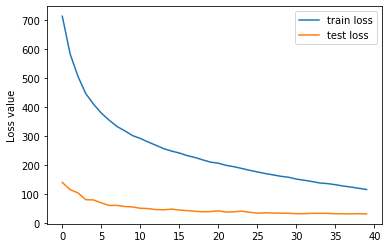

In [ ]:
import matplotlib.pyplot as plt
print(train_losses)
print(test_losses)
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Train loss is bigger in FGSM avd. training compared to natural traning


## saving 

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': adv_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'hw3_resnet_adv_trained')

## loading

In [11]:
adv_net = ResNet18()
adv_net = adv_net.to(device)
if device == 'cuda':
    adv_net = torch.nn.DataParallel(adv_net)
    cudnn.benchmark = True

optimizer =optim.SGD(adv_net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

checkpoint = torch.load('hw3_resnet_adv_trained')
adv_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = checkpoint['loss']

adv_net.eval()
# - or -
# model.train()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

## attacking

In [ ]:
attack_eps = [4/255,8/255,12/255]
for att_eps in attack_eps:
  print('Eps:',att_eps)
  wrong = 0
  correct = 0
  for i in range(len(org_images)):
    image = org_images[i:i+1]
    targets = org_labels[i:i+1]
    eps = base_eps
    perturbed_image,perturbation,outputs = fgsm(image,targets,adv_net,att_eps)
    # outputs= adv_net(perturbed_image)
    _, predicted = torch.max(outputs.data, 1)
    
    if predicted==targets:
      correct+=1
    else:
      wrong+=1
  print(correct,wrong)
  print(correct/(correct+wrong))
  print('--------')

Eps: 0.01568627450980392
85 15
0.85
--------
Eps: 0.03137254901960784
80 20
0.8
--------
Eps: 0.047058823529411764
73 27
0.73
--------


# Random Attack

## on Naturally Trained

In [ ]:

wrong = 0
correct = 0
for i in range(len(org_images)):
  image = org_images[i:i+1]
  targets = org_labels[i:i+1]
  eps = base_eps
  perturbation = torch.normal(8/255, 1/255, size=image.shape).to(device)
  perturbed_image = image + perturbation
  outputs= net(perturbed_image)
  _, predicted = torch.max(outputs.data, 1)
  if predicted==targets:
    correct+=1
  else:
    wrong+=1
print(correct,wrong)
print(correct/(correct+wrong))
print('--------')

89 11
0.89
--------


## on Adversarialy Trained

In [ ]:

wrong = 0
correct = 0
for i in range(len(org_images)):
  image = org_images[i:i+1]
  targets = org_labels[i:i+1]
  eps = base_eps
  perturbation = torch.normal(8/255, 1/255, size=image.shape).to(device)
  perturbed_image = image + perturbation
  outputs= adv_net(perturbed_image)
  _, predicted = torch.max(outputs.data, 1)
  if predicted==targets:
    correct+=1
  else:
    wrong+=1
print(correct,wrong)
print(correct/(correct+wrong))
print('--------')

93 7
0.93
--------


### FGSM is stronger than random attack

# Targeted FGSM

In [ ]:
def targeted_fgsm(x,targets,net,epsilon):

    x.requires_grad = True
    outputs= net(x)
    net.zero_grad()
    loss = criterion(outputs, targets)
    loss.backward()
    data_grad = x.grad.data
    sign_data_grad = data_grad.sign()
    perturbation = epsilon*sign_data_grad
    perturbed_image = x - perturbation
    outputs = net(perturbed_image)
    return perturbed_image, perturbation, outputs

## Target to Most Probable

### Targeted on Naturaly Trained

In [ ]:
attack_eps = 8/255

wrong = 0
correct = 0
for i in range(len(org_images)):
  image = org_images[i:i+1]
  targets = org_labels[i:i+1]
  eps = base_eps
  outputs= net(image)
  _, predicted = torch.max(outputs.data, 1)
  outputs.data[0,targets[0]] = -1000
  _, predicted = torch.max(outputs.data, 1)
  perturbed_image,perturbation,outputs = targeted_fgsm(image,predicted,net,attack_eps)
  # outputs= net(perturbed_image)
  _, predicted = torch.max(outputs.data, 1)
  if predicted==targets:
    correct+=1
  else:
    wrong+=1
print(correct,wrong)
print(correct/(correct+wrong))
print('--------')

31 69
0.31
--------


### Targeted on Adversarially Trained

In [ ]:
attack_eps = 8/255

wrong = 0
correct = 0
for i in range(len(org_images)):
  image = org_images[i:i+1]
  targets = org_labels[i:i+1]
  eps = base_eps
  outputs= adv_net(image)

  _, predicted = torch.max(outputs.data, 1)
  outputs.data[0,targets[0]] = -1000
  _, predicted = torch.max(outputs.data, 1)
  perturbed_image,perturbation,outputs = targeted_fgsm(image,predicted,adv_net,attack_eps)
  # outputs= adv_net(perturbed_image)
  _, predicted = torch.max(outputs.data, 1)
  if predicted==targets:
    correct+=1
  else:
    wrong+=1
print(correct,wrong)
print(correct/(correct+wrong))
print('--------')

80 20
0.8
--------


## Target to least Probable

### On Naturalyy Trained

In [ ]:
attack_eps = 8/255

wrong = 0
correct = 0
for i in range(len(org_images)):
  image = org_images[i:i+1]
  targets = org_labels[i:i+1]
  eps = base_eps
  outputs= net(image)
  _, predicted = torch.max(outputs.data, 1)
  outputs.data[0,targets[0]] = 1000
  _, predicted = torch.min(outputs.data, 1)

  perturbed_image,perturbation, outputs = targeted_fgsm(image,predicted,net,attack_eps)

  # outputs= net(perturbed_image)
  _, predicted = torch.max(outputs.data, 1)
  if predicted==targets:
    correct+=1
  else:
    wrong+=1
print(correct,wrong)
print(correct/(correct+wrong))
print('--------')

47 53
0.47
--------


### On adversarially Trained

In [ ]:
attack_eps = 8/255

wrong = 0
correct = 0
for i in range(len(org_images)):
  image = org_images[i:i+1]
  targets = org_labels[i:i+1]
  eps = base_eps
  outputs= adv_net(image)

  _, predicted = torch.max(outputs.data, 1)
  outputs.data[0,targets[0]] = 1000
  _, predicted = torch.min(outputs.data, 1)

  perturbed_image,perturbation, outputs = targeted_fgsm(image,predicted,adv_net,attack_eps)

  # outputs= adv_net(perturbed_image)
  _, predicted = torch.max(outputs.data, 1)
  if predicted==targets:
    correct+=1
  else:
    wrong+=1
print(correct,wrong)
print(correct/(correct+wrong))
print('--------')

90 10
0.9
--------


# PGD 

In [13]:
def pgd(x, targets, net, epsilon, alpha, iter):
    x.requires_grad = True
    net.zero_grad()
    perturbed_image = x.clone().detach().requires_grad_(True).to(x.device)
    for i in range(iter):
      _x_adv = perturbed_image.clone().detach().requires_grad_(True)
      outputs = net(_x_adv)
      loss = criterion(outputs, targets)
      loss.backward()
      data_grad = _x_adv.grad.data
      sign_data_grad = data_grad.sign()
      perturbation = alpha * sign_data_grad
      perturbed_image = perturbed_image + perturbation
      perturbed_image = torch.max(torch.min(perturbed_image, x + epsilon), x - epsilon)

    outputs = net(perturbed_image)
    perturbation = perturbed_image  - x 
    return perturbed_image, perturbation, outputs

## attacking FGSM advarsarialy trained model

In [20]:
attack_eps = 8/255
alpha = 3/255
iterations = [3,7,12]

for iter in iterations:
    wrong = 0
    correct = 0
    for i in range(len(org_images)):
      image = org_images[i:i+1]
      targets = org_labels[i:i+1]
      perturbed_image,perturbation,last_outputs = pgd(image,targets,net,attack_eps,alpha,iter)
      ouputs = adv_net(perturbed_image)
      _, predicted = torch.max(last_outputs.data, 1)
      if predicted==targets:
        correct+=1
      else:
        wrong+=1
    print('iter:',iter)
    print(correct,wrong)
    print(correct/(correct+wrong))
    print('--------')

iter: 3
78 22
0.78
--------
iter: 7
77 23
0.77
--------
iter: 12
77 23
0.77
--------


### with a fixed epsilon, attack accuracy does not change with increasing the number of steps when model is adversarially trained on same epsilon

## PGD Adversarial Training

In [ ]:
# Model
print('==> Building model..')
pgd_adv_net = ResNet18()
pgd_adv_net = pgd_adv_net.to(device)
if device == 'cuda':
    adv_net = torch.nn.DataParallel(pgd_adv_net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pgd_adv_net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [ ]:
alpha = 3/255
iter = 3
eps = 8/255
 
# Training
def pgd_adversarially_train(epoch):
    print('\nEpoch: %d' % epoch)
    pgd_adv_net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        perturbed_image,perturbation,outputs = pgd(inputs,targets,pgd_adv_net,eps,alpha,iter)
        optimizer.zero_grad()
        outputs = pgd_adv_net(perturbed_image)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss


def test(epoch):
    global acc
    pgd_adv_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = pgd_adv_net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss

train_losses = []
test_losses = []

for epoch in range(0,40):
    trl = pgd_adversarially_train(epoch)
    train_losses.append(trl)
    tstl = test(epoch)
    test_losses.append(tstl)
    scheduler.step()

print('Accuracy of the network on the test images: %d %%' % (acc))


Epoch: 0

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20

Epoch: 21

Epoch: 22

Epoch: 23

Epoch: 24

Epoch: 25

Epoch: 26

Epoch: 27

Epoch: 28

Epoch: 29

Epoch: 30

Epoch: 31

Epoch: 32

Epoch: 33

Epoch: 34

Epoch: 35

Epoch: 36

Epoch: 37

Epoch: 38

Epoch: 39
Accuracy of the network on the test images: 88 %


[712.4171396493912, 585.202928185463, 509.2744505405426, 455.8710853457451, 413.5561571717262, 382.66447734832764, 360.3420544266701, 339.30218601226807, 322.61420011520386, 309.99897557497025, 295.13930028676987, 283.43946301937103, 274.9205283522606, 262.94341361522675, 254.54589837789536, 245.734818816185, 238.24096286296844, 231.8815034031868, 222.45921793580055, 218.13765877485275, 210.577204734087, 204.71133759617805, 197.641084253788, 192.08951473236084, 186.78997614979744, 181.83334547281265, 175.8451009094715, 171.23839968442917, 166.8286046385765, 161.84279081225395, 159.1534664183855, 153.108060836792, 147.67145358026028, 143.78370982408524, 139.94420562684536, 135.66052943468094, 133.384999781847, 130.37383134663105, 123.8320775181055, 122.47270733118057]
[137.0699645280838, 114.1909339427948, 93.57810825109482, 83.82116740942001, 73.38765919208527, 67.01474085450172, 62.36912792921066, 57.74379462003708, 56.505678564310074, 55.57609283924103, 49.320122957229614, 57.7088188

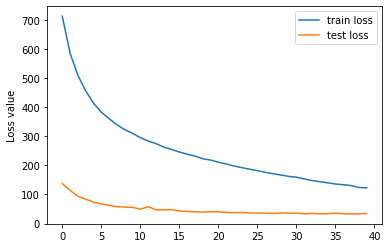

In [ ]:
import matplotlib.pyplot as plt
print(train_losses)
print(test_losses)
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Train loss is bigger in pgd avd. training compared to natural traning

## Saving

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': pgd_adv_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'pgd_adv_hw3_resnet')

## Loading

In [16]:
pgd_adv_net = ResNet18()
pgd_adv_net = pgd_adv_net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(pgd_adv_net)
    cudnn.benchmark = True

optimizer =optim.SGD(pgd_adv_net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

checkpoint = torch.load('pgd_adv_hw3_resnet')
pgd_adv_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = checkpoint['loss']

pgd_adv_net.eval()
# - or -
# model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## Attacking PGD advarsarially trained model

In [19]:
attack_eps = 8/255
alpha = 3/255
iterations = [3,7,12]

for iter in iterations:
    wrong = 0
    correct = 0
    for i in range(len(org_images)):
      image = org_images[i:i+1]
      targets = org_labels[i:i+1]
      perturbed_image,perturbation,last_outputs = pgd(image,targets,net,attack_eps,alpha,iter)
      # print(torch.min(perturbed_image),torch.max(perturbed_image))
      outputs = pgd_adv_net(perturbed_image)
      _, predicted = torch.max(outputs.data, 1)
      if predicted==targets:
        correct+=1
      else:
        wrong+=1
    print('iter:',iter)
    print(correct,wrong)
    print(correct/(correct+wrong))
    print('--------')

iter: 3
78 22
0.78
--------
iter: 7
77 23
0.77
--------
iter: 12
77 23
0.77
--------
